In [14]:
import os
import pandas as pd
from hyper_fewshot_ploter import join_data, disc_plot, src_trg_plot, wasserstein_plot,\
losses_plot

# Few Shot WDGRL: Experiences sur les hyperparamètres $\lambda$ et $\gamma$

## Configuration de l'expérience

### Les données

On utilise les données **microarray** comme *source* et les données **TCGA** comme *target*. Pour pallier le problème de disproportion des classes on a fait de l'oversampling sur les données *target*. Le tableau ci dessous montre la répartition des classes dans les différents domaines.

X | Source |  Target | Target oversampled
------------| ------------ | ------------- | -------------
Total | 22887 | 4693 | 6860 
Positif | 15298 | 4322 | 4322
Negatif | 7589 | 371 | 2538 
Training | 18310 | 3754 | 5488 
Validation | 4577 | 939 | 1372 

On note $S$ le domaine *source* et $T$ le domain *target* (sans labels). On considère un ensemble de points, noté $F$, de $T$ pour lesquels on a des labels. Ces points seront utilisé lors de l'apprentissage du WDGRL.

### Les modèles

On utilise deux modèles:
* Le modèle *WDGRLNet* qui est notre architecture pour l'apprentissage avec l'algorithme WDGRL.
* Le modèle *Discriminator* qui est un classificateur permettant de voir si $S$ et $T$ sont bien alignés.
Les architectures de ces modèles sont présentées sur les figures ci-dessous.

![WDGRL NET](wdgrl_net.png)

*WDGRLNet* a deux branches d'entrée GEN_S et GEN_T. Ces derbières sont les extracteurs de features de $S$ et $T$. La branche commune GEN est celle qui extrait des features représentatifs des deux domaines. 

![WDGRL NET](discriminator.png)

### Execution du programme

Le programme d'entrainement est lancé avec les paramètres ci dessous:

* $\lambda$: Paramètre de controle du modèle CRITIC optimal. Ce paramètre est variable dans cette expérience.
* $\gamma$: Paramètre de controle de la contrainte de lipschitzanité du modèle CRITIC. Ce paramètre est variable dans cette expérience.
* $\alpha_1=10^{-3}$: Pas d'optimisation de la loss de Wasserstein (CRITIC).
* steps = 10: Nombre d'iteration dans le calcul du CRITIC optimal.
* $\alpha_2=10^{-3}$: Pas d'optimisation de la loss de classification et la loss de Wasserstein avec les paramètres de CRITIC fixés.
* epochs = 40: Nombre d'epoch maximum pour l'apprentissage.
* bsize = 32
* patience = 3: nombre maximum d'iteration au bout des quelles on arrête l'apprentissage si la loss en validation ne s'améliore pas (earlystopping).
* min_epoch = 7: Nombre minimum d'epochs avant l'application du earlystopping.

$\lambda$ et $\gamma$ prennent les valeurs suivantes:

X | 1 | 2 | 3| 4 | 5 | 6 | 7
--- | --- | --- | --- | --- | --- | --- | ---
$\lambda$ | 0.001 | 0.01 | 0.1 | 1.0 | 2.0 | 5.0 | 10.0
$\gamma$ | 0.001 | 0.01 | 0.1 | 1.0 | 10.0 | 10.0 | 1000.0

Qaund on fait varier $\lambda$, $\gamma$ est fixé à 10. De même on fixe la valeur de $\lambda$ à 1 quand on fait varier $\gamma$.

## Variation de $\lambda$

In [2]:
logdir = '../log/'
hyper_name = 'lambda'
xlabel = '$\log(\\' + hyper_name +')$'
data_folder = os.path.join(logdir, f'micro_tcga_fs_wdgrl_{hyper_name}_2020-10-12_11-34-18')

# read meta data
meta_df = pd.read_csv(os.path.join(data_folder, 'meta'), 
                      index_col=0, header=0, names=['param', 'folder'])
n_params = meta_df.shape[0]

### Discriminateur

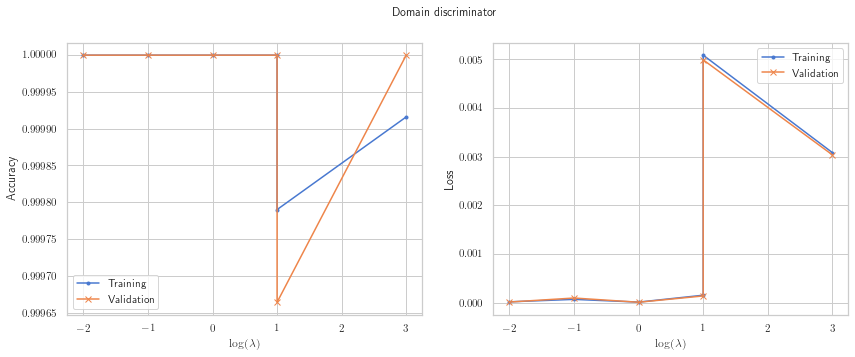

In [3]:
df = join_data(data_folder, 'disc', meta_df)
disc_plot(df, xlabel=xlabel)

L'accuracy du discriminateur decroit quand $\lambda$ augmente. Ce qui montre que les domaines s'allignent de mieux en mieux. On observe toutefois un pic pour la valeur $\lambda=2$ (Pourquoi ?? Voir la courbe de la loss de Wasserstein, elle fait un pique en 2.0 ce qui implique un mauvais alignement des domaine donc une augmentation de l'accuracy du discriminateur).

### Entrainement et validation

In [4]:
df_train = join_data(data_folder, 'train', meta_df)
df_valid = join_data(data_folder, 'valid', meta_df)

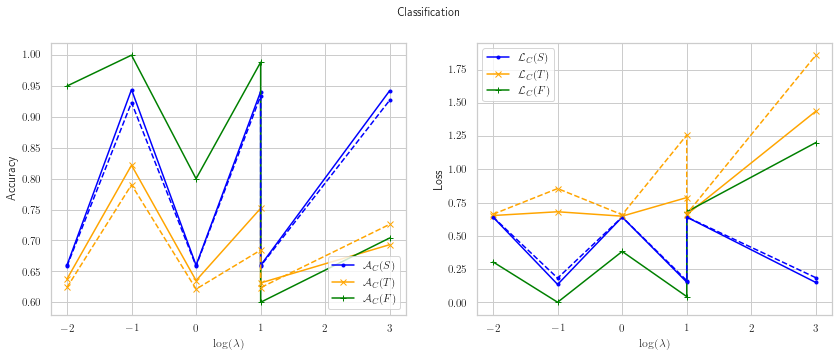

In [5]:
src_trg_plot(df_train, df_valid, xlabel=xlabel)

L'accuracy de $T$ commence à un peu plus de $80\%$. Même si les deux domaines ne sont pas bien allignés, $F$ permet d'extraire des feautures représentatifs de $S$ et $T$ et aussi de construire une bonne région de décision. Tout se passe comme si on alignait faiblement les domaines mais que $F$ permet de corriger la classification.

Les courbes en pointillés sont celles de la validation. L'accuracy de $S$ décroit avec l'augmentation de $\lambda$. La décroissence est lente pour $\lambda \leq 1.0$ et rapide pour $\lambda \gt 1.0$. On observe aussi une décroissance de l'accuracy de $T$ mais l'observation ne se généralise pas pour  $\lambda \gt 1.0$.

Cette observation montre qu'on donne plus d'importance à l'alignement des domaines par rapport à la classification des classes quand $\lambda$ augmente. En effet pour minimiser la loss, le terme dominant est minimisé pour arriver à un minimum global. Ainsi on se retrouve à minimiser la loss de Wasserstein plutôt que la loss de cross entropy. Prenons un petit example pour illustrer cette interprétation.

soit $\alpha \in [-5.0, 5.0]$, $h(x) = f(x) + \alpha g(x)$ avec $f(x) = -4e^{}-x^2$ et $g(x) = 2 - 4e^{-(x-2)^2}$. On pose $x_f^*$ la valeur de $x$ qui minimise la fonction $f$. On utilise la même notation pour les fonctions $g$ et $h$. On a $x_f^* = 0$, $x_g^* = 2$ et $x_h^* = x_f^*$ si $\alpha \lt 1.0$, $x_h^* = x_g^*$ si $\alpha \gt 1.0$ et $x_h^* \in \{x_f^*; x_g^*\}$ si $\alpha = 1.0$. Dans tous les cas pour minimiser $h$, on doit choisir entre minimiser $f$ ou minimiser $g$. On ne peux pas minimiser les deux fonctions simiultannément. 

On devrait donc envisager de modifier l'optimisation de la loss dans l'algorithme WDGRL (Pourquoi ça marche sur les images ??).

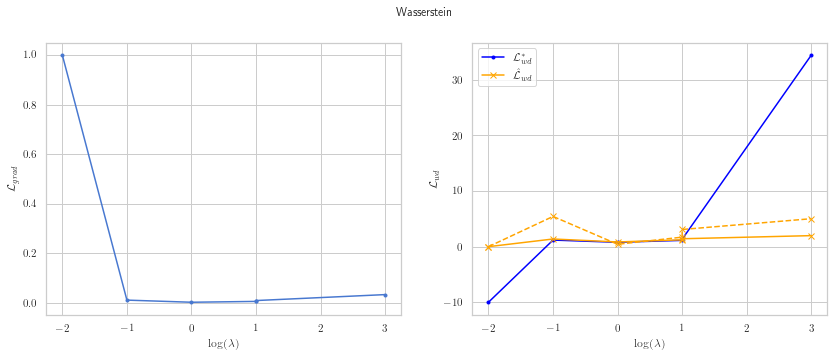

In [6]:
wasserstein_plot(df_train, df_valid, xlabel=xlabel)

La contraintre sur le gradient $\mathcal{L}_{grad}$, les losses de Wasserstein optimisée $\mathcal{L}_{wd}^{*}$, et estimée $\hat{\mathcal{L}}_{wd}$ décroissent quand $\lambda$ augments. Cependant on a un comportement innatendu dès que $\lambda \gt 1.0$. En effet les quantitées précédentes augmentent avant de se remettre à décroitre. Normalement puisqu'on donne plus d'importance à l'alignement des domaines quand $\lambda$ croît, ces quantitées devraient tendre vers zéro. (Pourquoi ce n'est pas le cas ??).

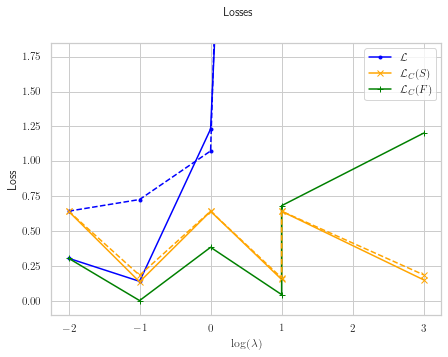

In [7]:
losses_plot(df_train, df_valid, xlabel=xlabel)

La loss totale croit avec $\lambda$ à cause des losses de classification. Le grand saut observé provient de l'annomalie observé sur les distances de Wasserstein pour $\lambda \gt 1.0$.

## Variation de $\gamma$

Ce paramètre permet de s'assurer que le modèle *CRITIC* soit 1-lipschitzien. Il n'assure pas qu'on ai le modèle *CRITIC* optimal mais plutôt qu'on cherche le modèle dans le bon ensemble.

In [8]:
hyper_name = 'gamma'
xlabel = '$\log(\\' + hyper_name +')$'
data_folder = os.path.join(logdir, f'micro_tcga_fs_wdgrl_{hyper_name}_2020-10-12_13-33-42')

# read meta data
meta_df = pd.read_csv(os.path.join(data_folder, 'meta'), 
                      index_col=0, header=0, names=['param', 'folder'])
n_params = meta_df.shape[0]

### Discriminateur

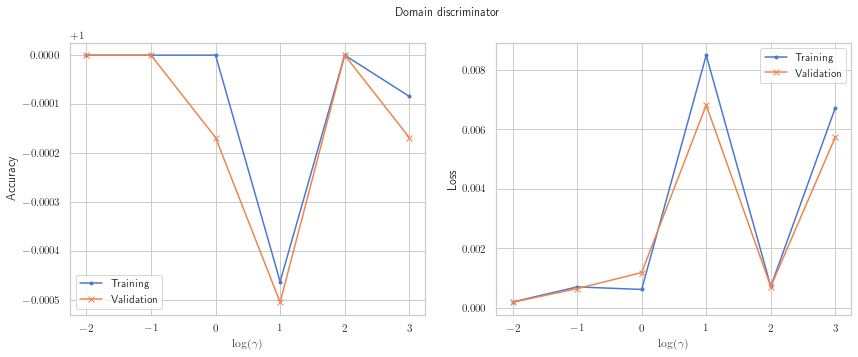

In [9]:
df = join_data(data_folder, 'disc', meta_df)
disc_plot(df, xlabel=xlabel)

L'accuracy du discriminateur est plus élevée dès que $\gamma \gt 1.0$. Les domaines sont mieux allignés pour les faibles valeurs de $\gamma$. A priori $\gamma$ n'a pas de réelle impacte sur l'alignement des domaines. On a pu l'observer lors de l'expérimentation sans fex shot, pour les même variations de $\gamma$, on n'avait pas d'influence remarquable de $\gamma$ sur l'allignement. On devrait donc investiguer sur l'impact du few shot (Qu'est ce qui change ??).

### Entrainement et validation

In [10]:
df_train = join_data(data_folder, 'train', meta_df)
df_valid = join_data(data_folder, 'valid', meta_df)

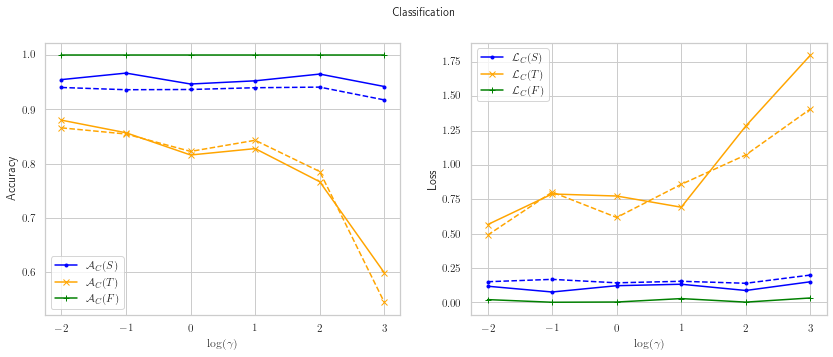

In [11]:
src_trg_plot(df_train, df_valid, xlabel=xlabel)

Les accuracies de $S$ et $T$ pour $\gamma \leq 0.1$ sont très basses bien que les courbes du discriminateur montrent un bon alignement des domaines pour ces valeurs de $\gamma$. On peut donc supposer qu'on s'est déplacé vers le minimum du modèle *CRITIC* (d'où la mauvaise qualité du classificateur). Pour $\gamma \gt 0.1$ les accuracies augmentent alors qu'on n'a pas un bon alignement des domaines. On s'est déplassé vers le minimum du *Générateur*.
Encore une fois la différence avec l'expérience sans few shot c'est qu'on observait pas un impacte directe de $\gamma$ sur ces valeurs.

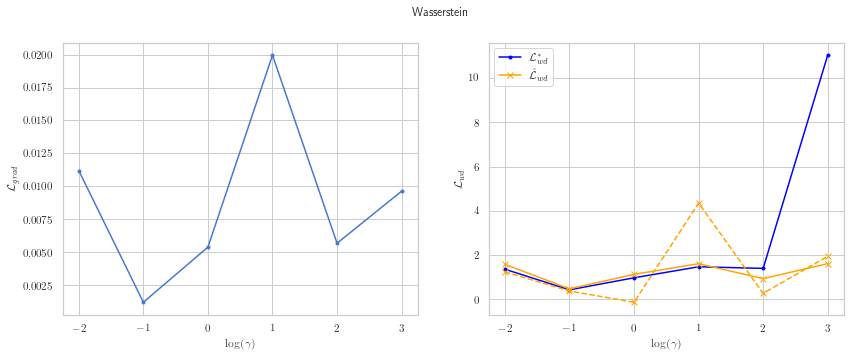

In [12]:
wasserstein_plot(df_train, df_valid, xlabel=xlabel)

Pour $0.1 \lt \gamma \lt 100$ les losses de Wasserstein sont (significativement) supérieures à zéro. Les features sélectionnées par le *Générateur* ne permettent pas de bien aligner les modèles. Puisqu'on sait que les accuracies augmentent pour ces valeurs, on peut conclure que le *Générateur* privilégie les features qui permettent de bien classer les domaines sans forcément les aligner. $\mathcal{L}_{grad}$ croît (Pourquoi ??).

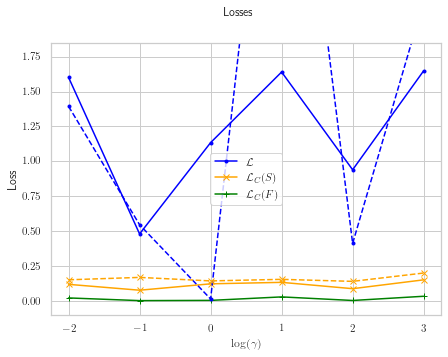

In [13]:
losses_plot(df_train, df_valid, xlabel=xlabel)

La loss totale varie comme celle de classification pour $\gamma \notin [1.0, 100.0[$ (zone dans laquelle les losses de Wasserstein sont sigificativement suppérieures à zéro). 